
# HackerEarth Deep Learning Challenge: 'Tis STILL the season to be jolly

You work for a social media platform. Your task is to create a solution using deep learning to discern whether a post is holiday-related in an effort to better monetize the platform.

Task-
You are given the following six categories. You are required to classify the images in the dataset based on these categories.

    Miscellaneous
    Christmas_Tree
    Jacket
    Candle
    Airplane
    Snowman


# Loading necessary libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense
from keras.models import Model
import os
import cv2

In [2]:
df_train = pd.read_csv('../input/hackereath-holiday-season-deep-learning-contest/dataset/train.csv')
df_train.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


# Number of training classes

In [3]:
df_train['Class'].value_counts()

Miscellaneous     2801
Christmas_Tree    1539
Jacket             640
Candle             593
Airplane           535
Snowman            361
Name: Class, dtype: int64

# Training data augmentation

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
         shear_range=0.2,
         zoom_range=0.2,
         horizontal_flip=True,
         width_shift_range=0.2,
         height_shift_range=0.2)

train_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                            directory="../input/hackereath-holiday-season-deep-learning-contest/dataset/train",
                                            x_col="Image",
                                            y_col="Class",
                                            batch_size=128,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(299,299))

Found 6469 validated image filenames belonging to 6 classes.


# Loading pre-trained models

In [5]:
model = tf.keras.applications.InceptionResNetV2(include_top=True,weights="imagenet")

225214464/225209952 [==============================] - 2s 0us/step


In [6]:
x = model.layers[-2].output
fc = Dense(1024,activation='relu')(x)
fc = Dense(512,activation='relu')(fc)
fc = Dense(256,activation='relu')(fc)
fc = Dense(6,activation='softmax')(fc)

In [7]:
model1 = Model(inputs=model.input,outputs=fc)
#model1.summary()

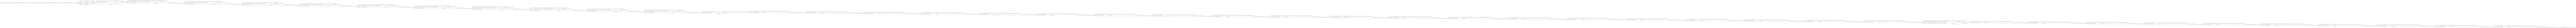

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='model.png', rankdir='LR')

In [9]:
plot_model(model1, to_file='model.png')

In [10]:
#freezing all the layers
for layer in model1.layers[:-16]:
    #print(l)
    layer.trainable = False

# Compiling model

In [11]:
model1.compile(optimizer='adam',loss ="categorical_crossentropy",metrics=["accuracy"])

# Training model

In [12]:
history = model1.fit_generator(train_generator, epochs=4)

Epoch 1/4
51/51 [==============================] - 169s 3s/step - loss: 0.5767 - accuracy: 0.7967
Epoch 2/4
51/51 [==============================] - 139s 3s/step - loss: 0.3028 - accuracy: 0.8896
Epoch 3/4
51/51 [==============================] - 139s 3s/step - loss: 0.2646 - accuracy: 0.9029
Epoch 4/4
51/51 [==============================] - 139s 3s/step - loss: 0.2274 - accuracy: 0.9202


In [13]:
classes = train_generator.class_indices

In [14]:
classes = dict((v,k) for k,v in classes.items())
classes = [classes[k] for k in classes]

In [15]:
Image = []
prediction = []


for i, file in enumerate(os.listdir('../input/hackereath-holiday-season-deep-learning-contest/dataset/test/')):
    Image.append(file)
    file = '../input/hackereath-holiday-season-deep-learning-contest/dataset/test/' + file

    img = image.load_img(file, target_size=(299,299,3)) 
    img = image.img_to_array(img)
    img = img/255
    pred = model1.predict(img.reshape(1,299,299,3))

    prediction.append(classes[np.argmax(pred[0])])

# Submission file creation

In [16]:
data=pd.DataFrame((zip(Image, prediction)),columns=['Image','Class'])
data.head()

,Image,Class
0,image7761.jpg,Miscellaneous
1,image3202.jpg,Miscellaneous
2,image688.jpg,Snowman
3,image233.jpg,Candle
4,image4332.jpg,Christmas_Tree


In [17]:
data.to_csv('submission.csv',index=False)